В случае регрессии разброс будет характеризоваться дисперсией, поэтому критерий информативности будет записан в виде

$$H(X) = \frac{1}{X}\sum_{i\in X}(y_{i} - \bar{y}(X))^{2},$$

где $\bar{y}(X)$ - среднее значение ответа в выборке $X$:

$$\bar{y}(X) = \frac{1}{|X|}\sum_{i\in X}y_{i}.$$

В задаче классификации есть несколько способов определить критерий информативности.

Обозначим через $p_{k}$ долю объектов класса $k$ в выборке $X$:

$$p_{k} = \frac{1}{|X|}\sum_{i\in X}[y_{i} = k].$$

$p_{k}$ будет характеризовать вероятность выдачи класса $k$.

_Критерий Джини_ или _индекс Джини_ выглядит следующим образом:

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}),$$

где $K$ - количество классов в наборе данных $X$.

Его минимум достигается когда все объекты в подмножестве относятся к одному классу, а максимум - при равном содержании объектов всех класов. Критерий информативности Джини можно интерпретировать как вероятность ошибки случайного классификатора.

Еще один критерий информативности - _энтропийный критерий_. Он также называется _энтропией Шеннона_ и записывается как

$$H(X) = - \sum^{K}_{k=1}p_{k}\text{log}_{2}p_{k}.$$

Минимум энтропии также достигается когда все объекты относятся к одному класссу, а максимум - при равномерном распределении. Стоит отметить, что в формуле полагается, что $0\text{log}_{2}0=0.$

# 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

__Добавил параметр max_depth в функцию build_tree__

In [49]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

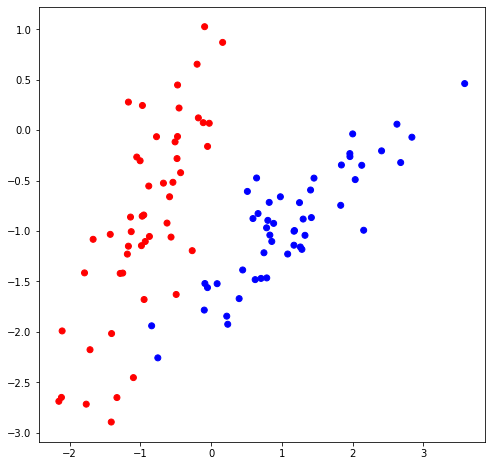

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, max_depth=-1):
    
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or max_depth == 1:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth-1)
    false_branch = build_tree(false_data, false_labels, max_depth-1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [50]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [51]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth=3)

In [52]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [53]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [54]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [55]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [56]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [57]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

Text(0.5, 1.0, 'Test accuracy=96.67')

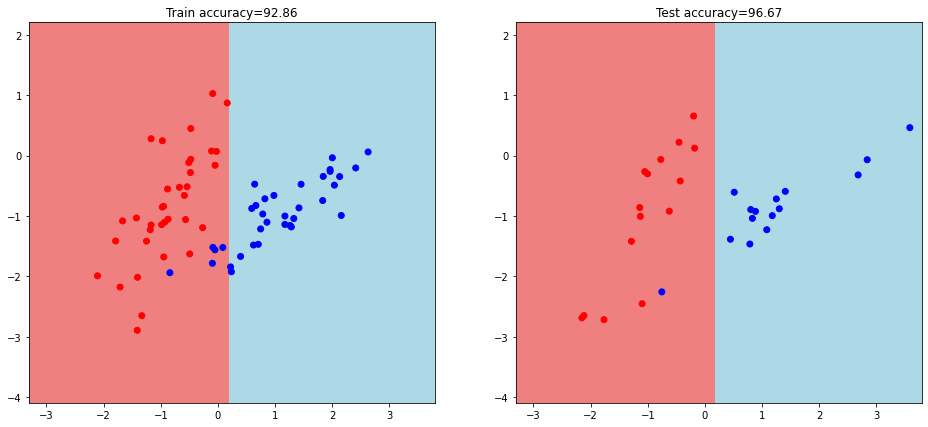

In [58]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

# 2*. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [167]:
X, y = datasets.make_regression(n_samples=100, 
                                n_features=1, 
                                n_informative=10, 
                                n_targets=1,
                                noise = 15,
                                random_state=42)

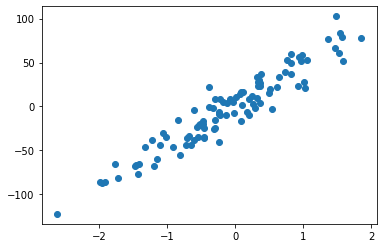

In [168]:
plt.scatter(X,y)

In [169]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [170]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.prediction = self.y.mean()
              

In [171]:
# Расчет критерия Джини

def crit(y):        
    return y.var()

In [172]:
# Расчет качества

def quality(left_y, right_y, current_crit):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_y.shape[0]) / (left_y.shape[0] + right_y.shape[0])
    
    return current_crit - p * crit(left_y) - (1 - p) * crit(right_y)

In [173]:
# Разбиение датасета в узле

def split(X, y, index, t):
    
    left = np.where(X[:, index] <= t)
    right = np.where(X[:, index] > t)
        
    true_X = X[left]
    false_X = X[right]
    true_y = y[left]
    false_y = y[right]
        
    return true_X, false_X, true_y, false_y

In [174]:
# Нахождение наилучшего разбиения

def find_best_split(X, y):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_crit = crit(y)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = X.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in X])
        
        for t in t_values:
            true_X, false_X, true_y, false_y = split(X, y, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_X) < min_leaf or len(false_X) < min_leaf:
                continue
            
            current_quality = quality(true_y, false_y, current_crit)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [175]:
# Построение дерева с помощью рекурсивной функции

def build_tree(X, y, max_depth=-1):
    
    quality, t, index = find_best_split(X, y)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or max_depth == 1:
        return Leaf(X, y)

    true_X, false_X, true_y, false_y = split(X, y, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_X, true_y, max_depth-1)
    false_branch = build_tree(false_X, false_y, max_depth-1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [176]:
def predict_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return predict_object(obj, node.true_branch)
    else:
        return predict_object(obj, node.false_branch)

In [177]:
def predict(X, tree):
    
    y_pred = []
    for obj in X:
        prediction = predict_object(obj, tree)
        y_pred.append(prediction)
    return y_pred

In [178]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

In [179]:
# Построим дерево по обучающей выборке
my_tree = build_tree(X_train, y_train)

In [180]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.46341769281246226
--> True:
  Индекс 0
  Порог -1.1509935774223028
  --> True:
    Индекс 0
    Порог -1.4785219903674274
    --> True:
      Прогноз: -81.92349461981976
    --> False:
      Прогноз: -63.6950809292853
  --> False:
    Индекс 0
    Порог -0.6017066122293969
    --> True:
      Прогноз: -37.929938920101975
    --> False:
      Прогноз: -23.528315801097136
--> False:
  Индекс 0
  Порог 0.6116762888408679
  --> True:
    Индекс 0
    Порог 0.08704706823817122
    --> True:
      Индекс 0
      Порог -0.18565897666381712
      --> True:
        Прогноз: -1.3264831256173804
      --> False:
        Прогноз: -4.499037530532969
    --> False:
      Индекс 0
      Порог 0.3142473325952739
      --> True:
        Прогноз: 9.784476960303204
      --> False:
        Прогноз: 20.065990734002835
  --> False:
    Индекс 0
    Порог 1.030999522495951
    --> True:
      Прогноз: 38.85435138620294
    --> False:
      Прогноз: 74.92935903645458


In [181]:
# Получим ответы для обучающей выборки 
train_answers = predict(X_train, my_tree)

In [182]:
# И получим ответы для тестовой выборки
answers = predict(X_test, my_tree)

In [183]:
from sklearn.metrics import r2_score

In [184]:
# r2 на тренировочной
r2_score(train_answers, y_train)

0.9334625327760404

In [185]:
# r2 на тестовой
r2_score(answers, y_test)

0.7587548131561698

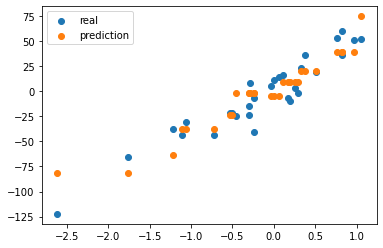

In [192]:
plt.scatter(X_test,y_test, label='real')
plt.scatter(X_test,answers,label='prediction')
plt.legend()